In [1]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv')
Atlanta_Distance['Total Bathrooms'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)
Atlanta_Distance = Atlanta_Distance.drop(columns=['latitude',
                                                  'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths',
                                                  	'street_address', 'has_pool', 'has_garage',
                                                 'Supercenter_POI', 'Convenience_POI', 'Supermarket_POI', 'Wholesale_POI', 'Variety_Store_POI', 'story_indicator'])
Atlanta_Distance = Atlanta_Distance.rename(columns={'Distance_SM': 'Supermarket', 'Distance_C': 'Convenience',
'Distance_WS': 'Wholesale', 'Distance_VS': 'Variety Store', 'Distance_SC': 'Supercenter', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                   'lot_size_in_square_feet': 'Lot Size(SQF)', 'number_of_garage_spaces': 'Garage Spaces', 'number_of_stories': 'Stories', 'year_built': 'Year Built'})
Atlanta_Distance['Year Built'] = Atlanta_Distance['Year Built'].astype('Int64')
Atlanta_Distance

,current_listing_price,listing_date,Year Built,Total Bedrooms,Living Area(SQF),Lot Size(SQF),Garage Spaces,Stories,Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,2865,3/12/2024,2002,4,3259.0,14810.400390,NaN,2.0,10917.45,6405.99,1654.08,2539.28,2715.74,2.5
1,2200,3/2/2024,<NA>,3,1993.0,NaN,NaN,NaN,32739.68,405.11,3065.55,492.63,1407.26,2.0
2,2000,2/15/2024,<NA>,3,1910.0,NaN,NaN,NaN,29267.11,4738.04,3780.13,25413.80,3213.19,2.0
3,1995,3/17/2024,<NA>,3,1134.0,NaN,NaN,NaN,9020.53,4356.55,2320.59,7857.71,2385.60,1.0
4,2800,3/3/2024,<NA>,4,2532.0,NaN,NaN,NaN,14750.79,6721.22,5625.35,11676.91,14263.22,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21010,1600,3/9/2023,<NA>,3,1367.0,NaN,NaN,NaN,47285.12,6409.21,2097.35,19852.16,4983.93,2.0
21011,2199,3/4/2024,<NA>,3,1696.0,871.199981,NaN,NaN,2009.36,6142.54,888.22,4864.86,1477.04,2.5
21012,2380,3/16/2024,2015,3,1944.0,4356.000065,NaN,NaN,1507.23,714.63,1158.08,1359.41,3952.51,3.5
21013,1900,3/4/2024,<NA>,4,1204.0,NaN,NaN,NaN,40632.51,1402.52,8779.81,10787.35,1242.13,2.0


In [2]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [3]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [4]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Lot Size(SQF)',
 'Garage Spaces',
 'Stories',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

In [5]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Year Built,Total Bedrooms,Living Area(SQF),Lot Size(SQF),Garage Spaces,Stories,Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,5.031097e-01,0.641662,1.314310,-0.032982,-7.850019e-16,0.781927,-0.636824,0.541928,-0.543506,-0.853198,-0.558318,0.177326
1,-1.091762e-14,-0.459475,0.111774,0.000000,-7.850019e-16,0.000000,1.494518,-1.156558,-0.087041,-1.210471,-0.973399,-0.475680
2,-1.091762e-14,-0.459475,0.032935,0.000000,-7.850019e-16,0.000000,1.155358,0.069832,0.144052,3.139891,-0.400516,-0.475680
3,-1.091762e-14,-0.459475,-0.704165,0.000000,-7.850019e-16,0.000000,-0.822093,-0.038145,-0.327959,0.075214,-0.663046,-1.781691
4,-1.091762e-14,0.641662,0.623754,0.000000,-7.850019e-16,0.000000,-0.262428,0.631150,0.740791,0.741912,3.104812,-0.475680
...,...,...,...,...,...,...,...,...,...,...,...,...
21010,-1.091762e-14,-0.459475,-0.482845,0.000000,-7.850019e-16,0.000000,2.915148,0.542839,-0.400154,2.169024,0.161205,-0.475680
21011,-1.091762e-14,-0.459475,-0.170338,-0.033377,-7.850019e-16,0.000000,-1.506863,0.467361,-0.791183,-0.447233,-0.951263,0.177326
21012,1.127320e+00,-0.459475,0.065230,-0.033278,-7.850019e-16,0.000000,-1.555905,-1.068952,-0.703911,-1.059161,-0.165986,1.483337
21013,-1.091762e-14,0.641662,-0.637674,0.000000,-7.850019e-16,0.000000,2.265398,-0.874252,1.760934,0.586626,-1.025782,-0.475680


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# Assuming RandomForest is part of your models dictionary
random_forest_model = RandomForestRegressor(random_state = 42)
# Define the full model pipeline including the preprocessor and RandomForestRegressor
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', random_forest_model)
])
# Fit the model pipeline
X = Atlanta_Distance.drop(columns='current_listing_price')
y = Atlanta_Distance['current_listing_price']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

random_forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Lot Size(SQF)',
       'Garage Spaces', 'Stories', 'Wholesale', 'Variety Store', 'Supermarket',
       'Supercenter', 'Convenience', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [7]:
val_score = random_forest_pipeline.score(X_val, y_val) 
print('Validation R^2:', val_score)

test_score = random_forest_pipeline.score(X_test, y_test)
print('Test R^2:', test_score)

Validation R^2: 0.5559021738107266
Test R^2: 0.5722475467005121


In [8]:
from sklearn.metrics import mean_squared_error 
y_val_pred = random_forest_pipeline.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
print('Validation Mean Squared Error:', val_mse)
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

y_test_pred = random_forest_pipeline.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

Validation Mean Squared Error: 370477.6972897987
Validation Root Mean Squared Error: 608.6687911251888
Test Mean Squared Error: 365345.6904896966
Test Root Mean Squared Error: 604.4383264566341


In [9]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val, y_val_pred)
test_mape = calculate_mape(y_test, y_test_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape)

Validation Mean Absolute Percentage Error (MAPE): 14.769509848586782
Test Mean Absolute Percentage Error (MAPE): 15.33900372326887


In [10]:
param = {
    'regressor__n_estimators': [300],
    'regressor__max_depth': [20],
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1],
    'regressor__max_features': ['sqrt']
}

random_forest_search = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=param,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,
    n_jobs=-1,
    verbose=2
)

random_forest_search.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute_mean',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Lot Size(SQF)',
       'Garage Spaces', 'Stories', 'Wholesale', 'Variety Store', 'Supermarket',
       'Supercenter', 'Convenience', 'Total Bath...
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [20],
                         'regressor__max_features': ['sqrt'],
                         'regressor__min_samples_leaf': [1],
                         'regressor__min_samples_split': [2],
                         'regressor__n_estimators': [300]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_root_mean_squared_error'],
             verbose=2)

In [11]:
best_model = random_forest_search.best_estimator_
results = random_forest_search.cv_results_
print("Best parameters:", random_forest_search.best_params_)
print("Best R^2:", random_forest_search.best_score_)

Best parameters: {'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best R^2: 0.5800800313331358


In [12]:
mean_r2_scores = results['mean_test_r2']
mean_mse_scores = -results['mean_test_neg_mean_squared_error']
mean_mape_scores = -results['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores = -results['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores)
print("Mean MAPE scores:", mean_mape_scores)
print("Mean R^2 scores:", mean_r2_scores)
print("Mean RMSE scores:", mean_RMSE_scores)

Mean MSE scores: [344443.15447728]
Mean MAPE scores: [0.14723827]
Mean R^2 scores: [0.58008003]
Mean RMSE scores: [586.03377986]


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_error
def calculate_scores(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return r2, mse, mape, rmse

In [14]:
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val, y_val_pred_tuned)

y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test, y_test_pred_tuned)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.5817
MSE: 348921.4715
MAPE: 0.1449
RMSE: 590.6958

Tuned Test Set Scores:
R²: 0.5911
MSE: 349255.2903
MAPE: 0.1492
RMSE: 590.9782


In [15]:
best_rf_model = best_model.named_steps['regressor']
feature_importances = best_rf_model.feature_importances_

In [16]:
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

In [17]:
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.2287
Feature: Total Bathrooms, Importance: 0.1372
Feature: Year Built, Importance: 0.0957
Feature: Supermarket, Importance: 0.0857
Feature: Convenience, Importance: 0.0773
Feature: Wholesale, Importance: 0.0772
Feature: Supercenter, Importance: 0.0738
Feature: Total Bedrooms, Importance: 0.0688
Feature: Variety Store, Importance: 0.0606
Feature: Lot Size(SQF), Importance: 0.0478
Feature: Stories, Importance: 0.0351
Feature: Garage Spaces, Importance: 0.0123


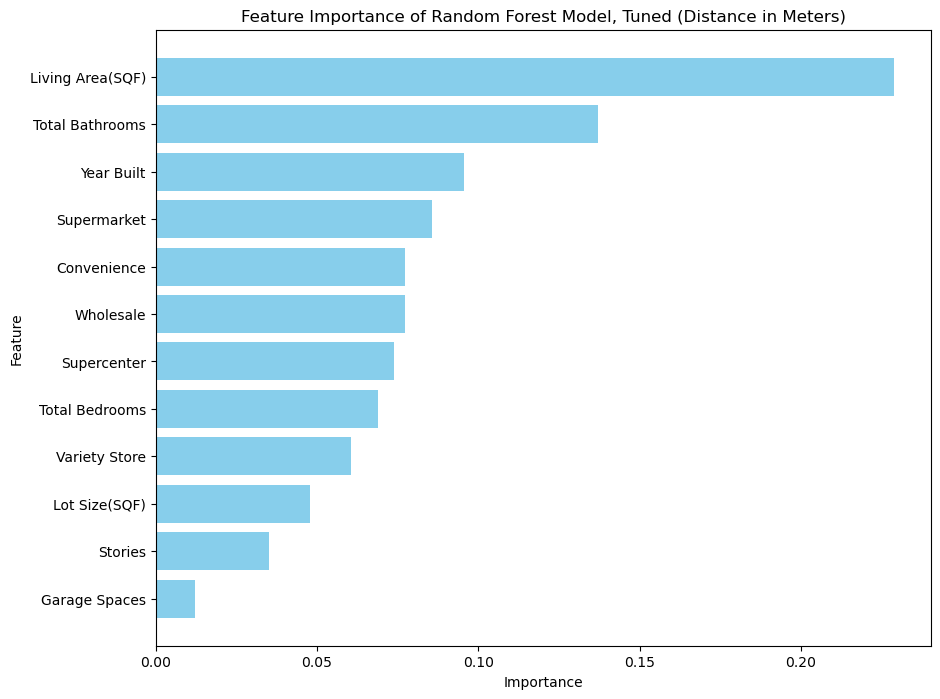

In [18]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Model, Tuned (Distance in Meters)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

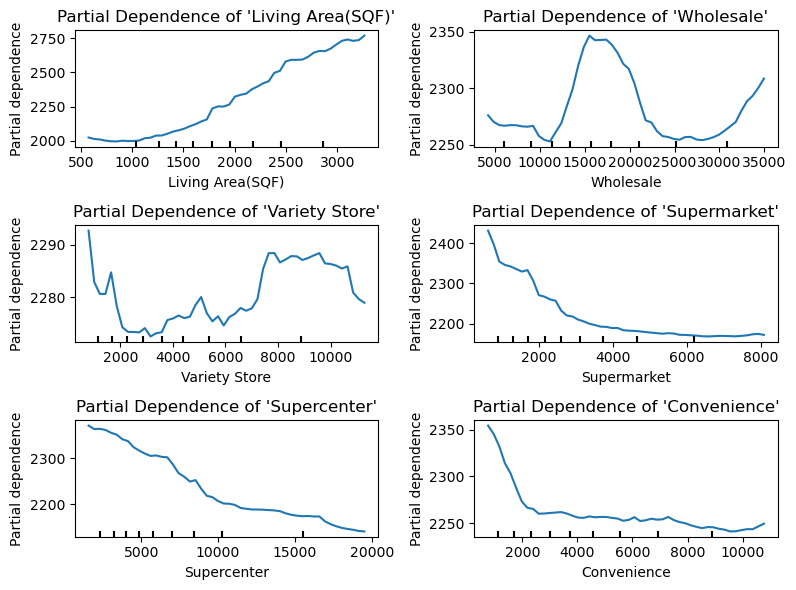

In [21]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import math

# List of features to include in the Partial Dependence Plots
features = [
    'Living Area(SQF)', 'Wholesale', 'Variety Store', 'Supermarket', 
    'Supercenter', 'Convenience',
]

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 2  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]  # Place in the correct subplot
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()